## Second dataset: RAF-DB

### Import packages

In [17]:
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Input, GlobalAveragePooling2D, ReLU, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

from tensorflow.keras.regularizers import l2


import matplotlib.pyplot as plt



### Artificially create an unlabeled subset of dataset for semi-supervised learning using pseudo-labeling

Note that this cell will error if run more than once since we've then already split the original training set.

In [2]:
# Adjust the base directory to point to training data
base_dir = 'datasets/RAF-DB/DATASET/train'  

# Directories for labeled and "unlabeled" training data
labeled_dir = os.path.join(base_dir, '../labeled_train')
unlabeled_dir = os.path.join(base_dir, '../unlabeled_train')

# Ensure the output directories exist
os.makedirs(labeled_dir, exist_ok=True)
os.makedirs(unlabeled_dir, exist_ok=True)

# Split ratio
split_ratio = 0.2  # 20% of training data is treated as "unlabeled"

# List classes/categories
classes = [dir for dir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, dir))]
classes = sorted(classes)

for class_name in classes:
    # Create target directories for both labeled and unlabeled data
    os.makedirs(os.path.join(labeled_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(unlabeled_dir, class_name), exist_ok=True)
    
    class_dir = os.path.join(base_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Split images into labeled and "unlabeled"
    labeled_imgs, unlabeled_imgs = train_test_split(images, test_size=split_ratio, random_state=42)
    
    # Move images to their new directories
    for img in labeled_imgs:
        shutil.move(os.path.join(class_dir, img), os.path.join(labeled_dir, class_name, img))
    
    for img in unlabeled_imgs:
        shutil.move(os.path.join(class_dir, img), os.path.join(unlabeled_dir, class_name, img))

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Preprocess images

In [3]:
# Initialize the data generators
train_data_gen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2  # Using 20% of the labeled data for validation
)

# Load the labeled training data and split it into training and validation sets
train_generator = train_data_gen.flow_from_directory(
    'datasets/RAF-DB/DATASET/labeled_train',  
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_data_gen.flow_from_directory(
    'datasets/RAF-DB/DATASET/labeled_train',  
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation' 
)

# Initialize unlabeled data generator
unlabeled_data_gen = ImageDataGenerator(rescale=1./255)

unlabeled_generator = unlabeled_data_gen.flow_from_directory(
    'datasets/RAF-DB/DATASET/unlabeled_train',  
    target_size=(48, 48),  
    batch_size=64, 
    color_mode="grayscale", 
    class_mode=None,  # must set to None for unlabeled data
    shuffle=False  
)

# Initialize the test data generator
test_data_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_data_gen.flow_from_directory(
    'datasets/RAF-DB/DATASET/test',  
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'  
)


Found 8789 images belonging to 7 classes.
Found 2195 images belonging to 7 classes.
Found 2457 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


### Set up example model

In [4]:
model = Sequential() # initialize Sequential model

# add 2 conv layers
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization()) 
# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# add 25% dropout 
model.add(Dropout(0.25))

# add 2 more conv layers, 2 more max pooling layers, and dropout again
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten into 1D vector
model.add(Flatten())
# fully-connected layer 
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax to turn into class probabilities
model.add(Dense(7, activation='softmax'))

model.summary()

# disable OpenCL
cv2.ocl.setUseOpenCL(False)

# set up learning rate scheduler, starting at 0.0001
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)

# use Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


2024-03-22 02:25:57.536962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

### Train the model on labeled data first

In [5]:
# Initial training with labeled data
model_info = model.fit(
    train_generator,
    steps_per_epoch=7855 // 64,  
    epochs=25,  
    validation_data=validation_generator,
    validation_steps=1959 // 64  
)

Epoch 1/25


2024-03-22 02:26:03.527973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-22 02:26:04.439644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-22 02:26:05.438334: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f359800c070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 02:26:05.438413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-22 02:26:05.451984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 02:26:05.657880: I ./tensorflow/compiler/jit/device_compiler.h:186] C

122/122 [==============================] - 18s 90ms/step - loss: 2.3493 - accuracy: 0.3253 - val_loss: 1.8850 - val_accuracy: 0.4104
Epoch 2/25
122/122 [==============================] - 7s 60ms/step - loss: 1.8285 - accuracy: 0.4641 - val_loss: 1.7710 - val_accuracy: 0.4151
Epoch 3/25
122/122 [==============================] - 6s 52ms/step - loss: 1.5603 - accuracy: 0.5279 - val_loss: 1.5410 - val_accuracy: 0.5156
Epoch 4/25
122/122 [==============================] - 5s 44ms/step - loss: 1.4195 - accuracy: 0.5659 - val_loss: 1.2442 - val_accuracy: 0.5786
Epoch 5/25
122/122 [==============================] - 6s 52ms/step - loss: 1.3219 - accuracy: 0.5984 - val_loss: 0.9651 - val_accuracy: 0.6635
Epoch 6/25
122/122 [==============================] - 6s 52ms/step - loss: 1.2226 - accuracy: 0.6236 - val_loss: 0.8771 - val_accuracy: 0.7047
Epoch 7/25
122/122 [==============================] - 6s 51ms/step - loss: 1.1437 - accuracy: 0.6457 - val_loss: 0.8441 - val_accuracy: 0.7141
Epoch 8/2

### Visualizations

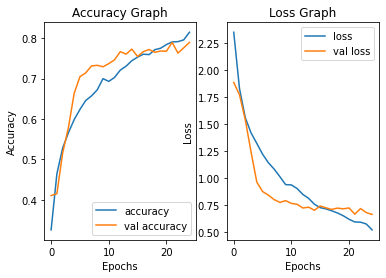

In [6]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Now, train on unlabeled data

In [7]:
# Step 1: Predict class probabilities for the unlabeled data
predicted_probabilities = model.predict(unlabeled_generator)

# Step 2: Generate pseudo-labels from these predictions
pseudo_labels = np.argmax(predicted_probabilities, axis=1)

# Define a confidence threshold
confidence_threshold = 0.9

# Step 3: Create a mask for predictions that exceed the confidence threshold
high_confidence_mask = np.max(predicted_probabilities, axis=1) > confidence_threshold

# Apply the mask to filter out the filenames and predictions
high_confidence_filenames = np.array(unlabeled_generator.filenames)[high_confidence_mask]
high_confidence_predictions = pseudo_labels[high_confidence_mask]



39/39 [==============================] - 3s 65ms/step


In [8]:
np.unique(pseudo_labels)

array([0, 1, 2, 3, 4, 5, 6])

In [9]:
# Organize images
for filename, pseudo_label in zip(high_confidence_filenames, high_confidence_predictions):
#     # Ensure the pseudo_label is an integer or a valid class name
#     assert isinstance(pseudo_label, int), "Pseudo-label must be an integer"
    
    # Define the source path for the pseudo-labeled image
    source_path = os.path.join(unlabeled_dir, filename)
    
    # Define the destination directory based on the pseudo-label
    destination_dir = os.path.join(labeled_dir, str(pseudo_label + 1))
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir, exist_ok=True)
    
    # Define the destination path for the pseudo-labeled image
    destination_path = os.path.join(destination_dir, os.path.basename(filename))
    
    # Copy the pseudo-labeled image to the destination
    shutil.copy(source_path, destination_path)


In [10]:
labeled_dir

'datasets/RAF-DB/DATASET/train/../labeled_train'

In [11]:
checkpoints_path = os.path.join(labeled_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)

In [12]:
# Initialize the data generator for the combined labeled and pseudo-labeled data
train_data_gen_combined = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Load the combined training data
train_generator_combined = train_data_gen_combined.flow_from_directory(
    labeled_dir,  # both labeled and unlabeled images
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    subset='training'
)


Found 8989 images belonging to 7 classes.


In [13]:
print(train_generator_combined.class_indices)
print(validation_generator.class_indices)

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


In [15]:
# Retrain the model on the combined dataset
steps_per_epoch = train_generator_combined.samples // train_generator_combined.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

model_info = model.fit(
    train_generator_combined,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/10
140/140 [==============================] - 8s 56ms/step - loss: 0.4946 - accuracy: 0.8261 - val_loss: 0.6840 - val_accuracy: 0.7909
Epoch 2/10
140/140 [==============================] - 7s 51ms/step - loss: 0.4597 - accuracy: 0.8375 - val_loss: 0.6738 - val_accuracy: 0.7932
Epoch 3/10
140/140 [==============================] - 7s 50ms/step - loss: 0.4715 - accuracy: 0.8342 - val_loss: 0.6865 - val_accuracy: 0.7872
Epoch 4/10
140/140 [==============================] - 7s 48ms/step - loss: 0.4376 - accuracy: 0.8425 - val_loss: 0.6759 - val_accuracy: 0.7918
Epoch 5/10
140/140 [==============================] - 7s 51ms/step - loss: 0.4228 - accuracy: 0.8458 - val_loss: 0.6567 - val_accuracy: 0.7992
Epoch 6/10
140/140 [==============================] - 7s 49ms/step - loss: 0.4083 - accuracy: 0.8545 - val_loss: 0.6865 - val_accuracy: 0.7923
Epoch 7/10
140/140 [==============================] - 7s 50ms/step - loss: 0.3966 - accuracy: 0.8561 - val_loss: 0.6804 - val_accuracy: 0.7900

## Now, do this again but with our actual model (with attention)

In [18]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1  
    filters = init.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    se = Reshape((1, 1, filters))(se)
    x = Multiply()([init, se])
    return x

# Model definition, use Functional API instead of Sequential
input_img = Input(shape=(48, 48, 1))

# 1st conv block
x = Conv2D(32, kernel_size=(3, 3), padding='same')(input_img)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  

# 2nd conv block
x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# 3rd conv block
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  
x = MaxPooling2D(pool_size=(2, 2))(x)

# 4th conv block
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Additional Dense layer to increase complexity
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(7, activation='softmax')(x)

model_with_se = Model(inputs=input_img, outputs=output)


# Set up the learning rate schedule and compile the model
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

model_with_se.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_with_se.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 48, 48, 32)           320       ['input_2[0][0]']             
                                                                                                  
 re_lu_1 (ReLU)              (None, 48, 48, 32)           0         ['conv2d_5[0][0]']            
                                                                                                  
 batch_normalization_6 (Bat  (None, 48, 48, 32)           128       ['re_lu_1[0][0]']             
 chNormalization)                                                                             

In [19]:
#initial training on just labeled
model_with_se_info = model_with_se.fit(
    train_generator,
    steps_per_epoch=7855 // 64,  
    epochs=25,  
    validation_data=validation_generator,
    validation_steps=1959 // 64  
)

Epoch 1/25


2024-03-22 02:32:33.773432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


122/122 [==============================] - 14s 55ms/step - loss: 2.5864 - accuracy: 0.2760 - val_loss: 2.0166 - val_accuracy: 0.2000
Epoch 2/25
122/122 [==============================] - 6s 52ms/step - loss: 2.0088 - accuracy: 0.4046 - val_loss: 3.3455 - val_accuracy: 0.1937
Epoch 3/25
122/122 [==============================] - 7s 54ms/step - loss: 1.7706 - accuracy: 0.4769 - val_loss: 3.7401 - val_accuracy: 0.1948
Epoch 4/25
122/122 [==============================] - 7s 53ms/step - loss: 1.6047 - accuracy: 0.5159 - val_loss: 2.3032 - val_accuracy: 0.3057
Epoch 5/25
122/122 [==============================] - 6s 52ms/step - loss: 1.4876 - accuracy: 0.5420 - val_loss: 1.3036 - val_accuracy: 0.5625
Epoch 6/25
122/122 [==============================] - 6s 51ms/step - loss: 1.3872 - accuracy: 0.5663 - val_loss: 1.0353 - val_accuracy: 0.6391
Epoch 7/25
122/122 [==============================] - 6s 49ms/step - loss: 1.3117 - accuracy: 0.5867 - val_loss: 0.9363 - val_accuracy: 0.6766
Epoch 8/2

In [20]:
#retrain on combined
steps_per_epoch = train_generator_combined.samples // train_generator_combined.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

model_with_se_info = model_with_se.fit(
    train_generator_combined,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/10
140/140 [==============================] - 7s 52ms/step - loss: 0.6063 - accuracy: 0.7855 - val_loss: 0.7080 - val_accuracy: 0.7753
Epoch 2/10
140/140 [==============================] - 7s 47ms/step - loss: 0.5693 - accuracy: 0.8000 - val_loss: 0.6702 - val_accuracy: 0.7790
Epoch 3/10
140/140 [==============================] - 7s 49ms/step - loss: 0.5536 - accuracy: 0.8009 - val_loss: 0.6735 - val_accuracy: 0.7767
Epoch 4/10
140/140 [==============================] - 7s 48ms/step - loss: 0.5357 - accuracy: 0.8113 - val_loss: 0.6797 - val_accuracy: 0.7826
Epoch 5/10
140/140 [==============================] - 7s 49ms/step - loss: 0.5115 - accuracy: 0.8208 - val_loss: 0.6798 - val_accuracy: 0.7803
Epoch 6/10
140/140 [==============================] - 7s 48ms/step - loss: 0.5087 - accuracy: 0.8208 - val_loss: 0.6878 - val_accuracy: 0.7757
Epoch 7/10
140/140 [==============================] - 8s 54ms/step - loss: 0.4916 - accuracy: 0.8262 - val_loss: 0.6835 - val_accuracy: 0.7721

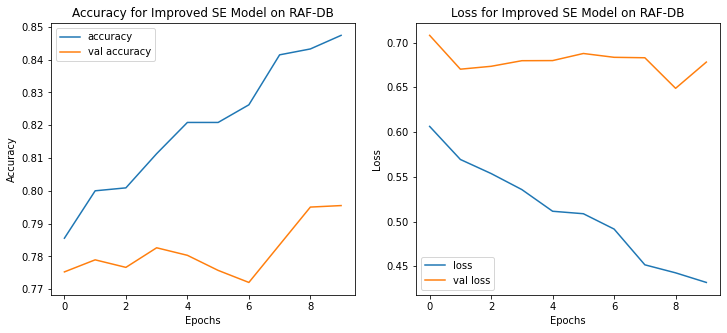

In [22]:
# visualize

accuracy = model_with_se_info.history['accuracy']
val_accuracy = model_with_se_info.history['val_accuracy']
loss = model_with_se_info.history['loss']
val_loss = model_with_se_info.history['val_loss']

plt.figure(figsize=(12, 5))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy for Improved SE Model on RAF-DB')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss for Improved SE Model on RAF-DB')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
results = model_with_se.evaluate(test_generator, steps=len(test_generator))

# Test results
print("Test loss:", results[0])
print("Test accuracy:", results[1])

48/48 [==============================] - 5s 97ms/step - loss: 0.7565 - accuracy: 0.7643
Test loss: 0.7564506530761719
Test accuracy: 0.7643415927886963
